In [1]:
%%shell
rm -rf fdr
git clone https://github.com/Davidvandijcke/fdr.git
pip install geopandas folium matplotlib mapclassify contextily rasterio scikit-image geocube pandas==2.0.0



UsageError: Cell magic `%%shell` not found.


In [1]:
from FDR import FDR

In [2]:
# load libraries
import geopandas as gpd
import numpy as np
import os
import urllib
import zipfile
import re
#from geocube.api.core import make_geocube
import rasterio as rio
from rasterio.mask import mask
from rasterio.transform import from_origin
# from skimage import data, img_as_float, io
# from skimage.segmentation import chan_vese
from PIL import Image
import matplotlib.pyplot as plt
from scipy.io import loadmat
# from geocube.api.core import make_geocube
import boto3

In [3]:
# # set path
bsdir = "/home/dvdijcke/"
data_out =  bsdir + "data/out/ukr/" # "s3://ipsos-dvd/fdd/data/out/ukr/" # set to desired directory
data_in = bsdir + "data/in/ukr/"
# bsdir = "/Users/davidvandijcke/Dropbox (University of Michigan)/rdd/data/out/"

In [38]:

def getSpaceTimeDwells(start, end):
    """Get the spatio-temporal data for the frontline dwells
    Args:
        start (int): first week of 2022 to consider
        end (int): last week of 2022 to consider
    """
    grid = gpd.read_file(data_out + "grid_dwells_weekly.geojson")
    grid = grid.set_crs("EPSG:6381", allow_override=True)
    
    # assign first-period matrices
    no_weeks = len(range(start,end))
    agg_gdf = grid[grid.week==start]
    X1 = np.array(agg_gdf.geometry.centroid.x)
    X2 = np.array(agg_gdf.geometry.centroid.y)
    X = np.stack([X2, X1]).T 
    Y = np.array(agg_gdf['count_ratio'])

    # assign spatio-temporal matrices
    Y_t = Y.copy()
    qtile = np.quantile(Y_t, 0.9) # import to also winsorize first period
    Y_t[Y_t > qtile] = qtile # 0.5

    
    # Step 1: Duplicate the array N times
    duplicated_array = np.tile(X, (no_weeks, 1))

    # Step 2: Create a column indicating the repetition number
    repetition_column = np.repeat(np.arange(start, end), len(X)).reshape(-1, 1)

    # Step 3: Concatenate the duplicated array with the repetition column
    X_t = np.hstack((duplicated_array, repetition_column))
    
    
    for week in range(start+1,end):
        agg_gdf = grid[grid.week==week]
        Y = np.array(agg_gdf['count_ratio'])
        qtile = np.quantile(Y, 0.9)
        Y[Y > qtile] = qtile # 0.5
        Y_t = np.hstack([Y_t, Y]) # first week is first, then chronologically stacked
        
    # winsorize
    # qtile = np.quantile(Y_t, 0.95)
    # Y_t[Y_t > qtile] = qtile # 0.5
    
    return(X, X_t, Y_t, no_weeks)


In [6]:
start = 9
end = 19
grid = gpd.read_file(data_out + "grid_dwells_weekly.geojson")
grid = grid.set_crs("EPSG:6381", allow_override=True)


In [95]:
grid = gpd.read_file(data_out + "grid_dwells_weekly.geojson")
grid = grid.set_crs("EPSG:6381", allow_override=True)

# assign first-period matrices
no_weeks = len(range(start,end))
agg_gdf = grid[grid.week==start]
X1 = np.array(agg_gdf.geometry.centroid.x)
X2 = np.array(agg_gdf.geometry.centroid.y)
X = np.stack([X2, X1]).T 
Y = np.array(agg_gdf['count_ratio'])

# assign spatio-temporal matrices
Y_t = Y.copy()
qtile = np.quantile(Y_t, 0.9)
Y_t[Y_t > qtile] = qtile # 0.5

# Step 1: Duplicate the array N times
duplicated_array = np.tile(X, (no_weeks, 1))

# Step 2: Create a column indicating the repetition number
repetition_column = np.repeat(np.arange(start, end), len(X)).reshape(-1, 1)

# Step 3: Concatenate the duplicated array with the repetition column
X_t = np.hstack((duplicated_array, repetition_column))


for week in range(start+1,end):
    agg_gdf = grid[grid.week==week]
    Y = np.array(agg_gdf['count_ratio'])
    # winsorize
    qtile = np.quantile(Y, 0.9)
    Y[Y > qtile] = qtile # 0.5
    Y_t = np.hstack([Y_t, Y]) # first week is first, then chronologically stacked



<Axes: >

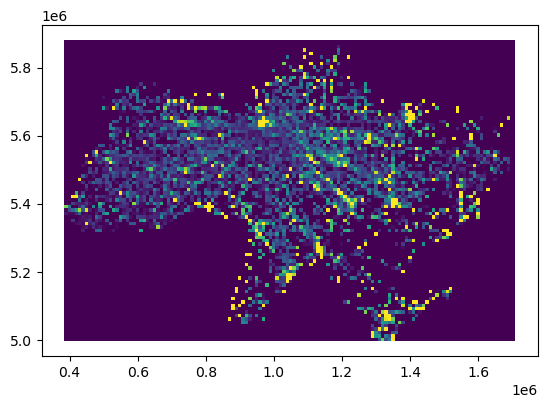

In [149]:
grid[grid.week == 37].plot(column="count_ratio", vmax=0.3)

### Now let's segment the map of mobile device activity

In [39]:


#----------------
# process data
#----------------

start = 9
end = 51
X, X_t, Y_t, no_weeks = getSpaceTimeDwells(start, end)


In [119]:

#----------------
# parameters
#----------------
S = 16
N = 1000
lmbda = 50
nu = 0.05
num_samples = 100 # 225 #  400 # 400 # 400 # 200
R = 1 # 3 # 3 # 3 # 5
num_gpus = 1
num_cpus = 4
iter = 100000
lmbda_max = 50
nu_min = 0.001
nu_max = 1

# import SURE parameters
import pickle
file = open(bsdir + 'fdr/src/analysis/frontline_dwells_temporal_SURE_9_51_june18.pkl','rb')
res = pickle.load(file)
file.close()
best = res.get_best_result(metric = "score", mode = "min")
config = best.metrics['config']
lmbda, nu = config['lmbda'], config['nu']

print(f"lambda {lmbda}, nu {nu}")

#--------
grid_n = np.array([len(np.unique(X[:,0])), len(np.unique(X[:,1])), no_weeks])
model = FDR(Y_t, X_t, level = S, lmbda = lmbda, nu = nu, iter = iter, tol = 5e-5, pick_nu = "MS", 
            CI=False, rectangle=False, grid_n=grid_n, scripted=False) 

lambda 34.89135689703822, nu 0.004070303505558474


In [19]:
model.grid_y.shape

(120, 193, 10, 1)

In [20]:
(model.grid_y[:,:, 1,...].squeeze() == model.grid_y[:,:, 5,...].squeeze()).all()

False

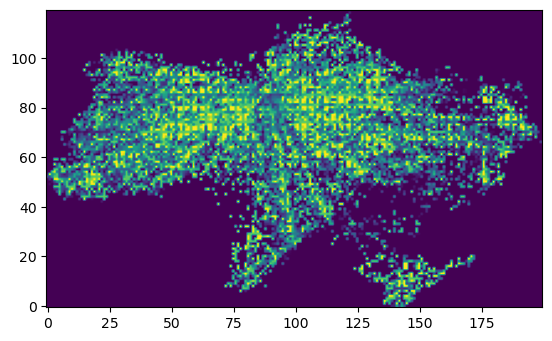

In [116]:
plt.imshow(model.grid_y[:,:,15,...].squeeze(), origin="lower")

In [120]:
results = model.run()

/home/dvdijcke/miniconda3/envs/fdd_new/lib/python3.9/site-packages/FDR/primaldual_multi_scaled_tune.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tauu = torch.tensor(  1.0 / torch.sqrt(denom) * res, device=dev)  # torch.tensor(  1.0 / 6.0 * res, device=dev) # *res
/home/dvdijcke/miniconda3/envs/fdd_new/lib/python3.9/site-packages/FDR/primaldual_multi_scaled_tune.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigmap = torch.tensor( 1.0 / torch.sqrt(denom)  * res, device=dev) # torch.tensor( (1.0 / (3.0 + l))  * res, device=dev) # *res


In [58]:
file_name = os.path.join(bsdir + 'frontline_dwells_temporal_run_23jul2024.pkl')
with open(file_name, 'wb') as file:
    pickle.dump(results, file)

In [12]:
results['it']

1300

In [17]:
## read function
import pickle
file_name = 'frontline_dwells_temporal_run_9_51.pkl'
file = open(file_name,'rb')
results = pickle.load(file)
file.close()

In [79]:
model.nu

0.004070303505558474

In [122]:
u = results['u']
J_grid = results['J']

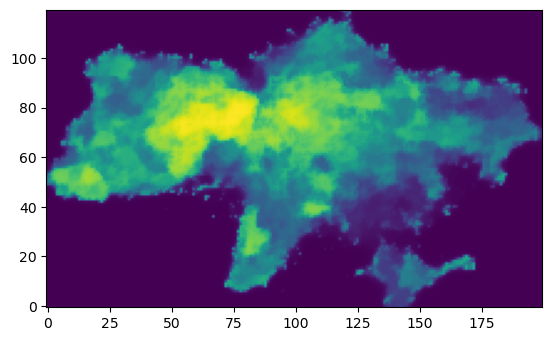

In [124]:
plt.imshow(u[:,:,1], origin ="lower")
plt.show()

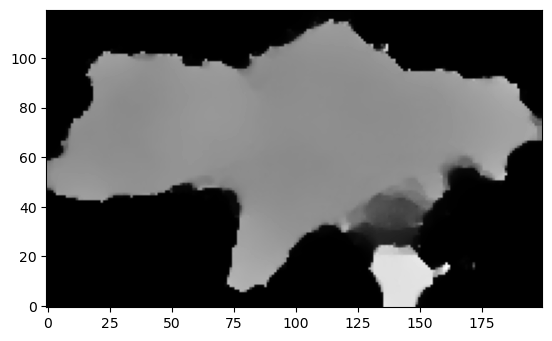

In [97]:
plt.imshow(u[:,:,1], origin ="lower", cmap = "gray")
plt.show()

In [116]:
idx = 30
print(f"mean {u[:,:,idx].mean()}, min {u[:,:,idx].min()}, max {u[:,:,idx].max()}")

mean 0.06529586690953867, min 0.05219633003761028, max 0.4858411206253644


In [47]:
idx = 30
print(f"mean {u[:,:,idx].mean()}, min {u[:,:,idx].min()}, max {u[:,:,idx].max()}")

mean 0.06529586690953867, min 0.05219633003761028, max 0.4858411206253644


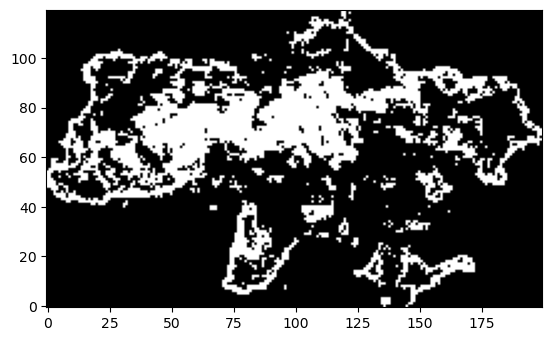

In [125]:
plt.imshow(J_grid[:,:,3], origin ="lower", cmap = "gray")
plt.show()

In [31]:
J_grid.max()

1

In [ ]:
xmin = np.min(model.X_raw, axis=0)
xmax = np.max(model.X_raw - xmin)
X_coord = model.grid_x  * xmax +  np.flip(xmin)

ValueError: operands could not be broadcast together with shapes (120,200,3) (2,) 

In [113]:
model.grid_x.shape

(120, 200, 10, 3)

In [191]:
X_coord = X_coord.reshape(-1, X_coord.shape[-1])
Y_coord = u.flatten()

In [192]:
u_gdf = gpd.GeoDataFrame(np.stack([Y_coord, J_grid.flatten()]).T, 
                         geometry=gpd.points_from_xy(X_coord[:,0], X_coord[:,1]), crs = grid.crs, columns=['u', 'J_grid'])
u_gdf.loc[u_gdf['J_grid'] == 0, 'J_grid'] = np.nan

In [114]:
# import contextily as ctx
# fig, ax =  plt.subplots(figsize=(10,10))
#u_gdf.plot(column = "J_grid", cmap = "binary", ax=ax, alpha=0.5)
# ctx.add_basemap(ax, crs=u_gdf.crs.to_string())

In [107]:
# merge in ISW shapefile
isw = gpd.read_file(data_in + "Ukraine_Conflict_Mapping_ARCGIS_Shapefiles/Russian_CoT_in_Ukraine_Shapefiles/UkraineControlMapAO01MAR2023.zip")
# isw = gpd.read_file(data_in + "Ukraine_Conflict_Mapping_ARCGIS_Shapefiles/Russian_Claimed_CoT/ClaimedRussianTerritoryinUkraineJUL05.zip")
isw = isw.to_crs(grid.crs)

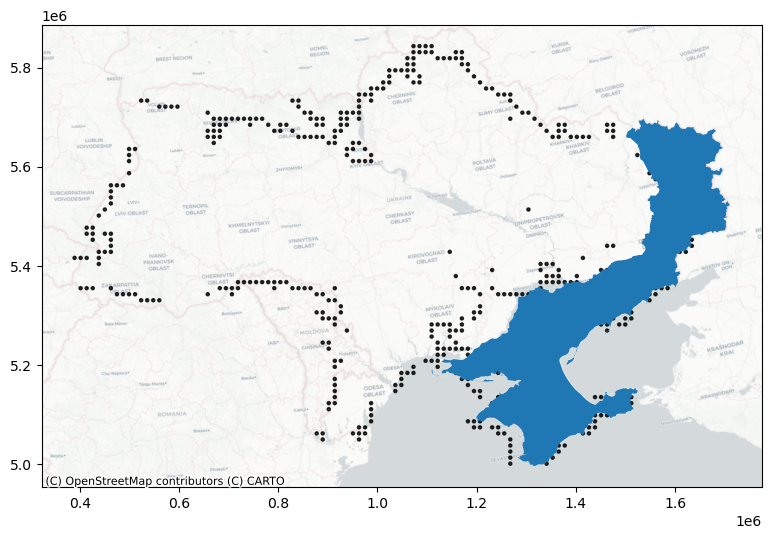

In [193]:
fig, ax = plt.subplots(figsize=(10, 6))
u_gdf.plot(ax=ax, cmap = "binary_r", column="J_grid", alpha=0.8, s=5)
isw.plot(ax=ax)
ctx.add_basemap(ax, crs=u_gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)
file_name = "isw_frontline.png"
fn = bsdir + "rdd/results/figs/" + file_name
plt.savefig(fn)
# s3 = boto3.client('s3')
# with open(fn, "rb") as f:
#     s3.upload_fileobj(f, "ipsos-dvd", "fdd/results/figs/" + file_name)


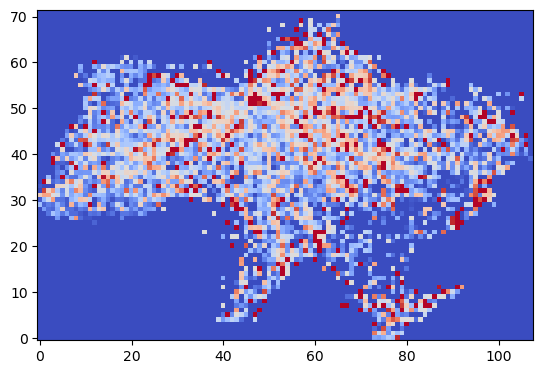

In [58]:
plt.imshow(model.grid_y, origin="lower", cmap="coolwarm")

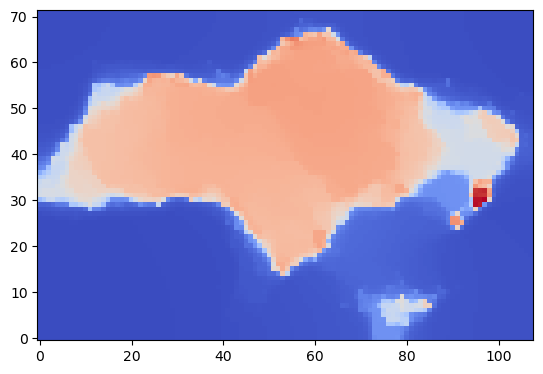

In [ ]:
plt.imshow(u, origin="lower", cmap="coolwarm")

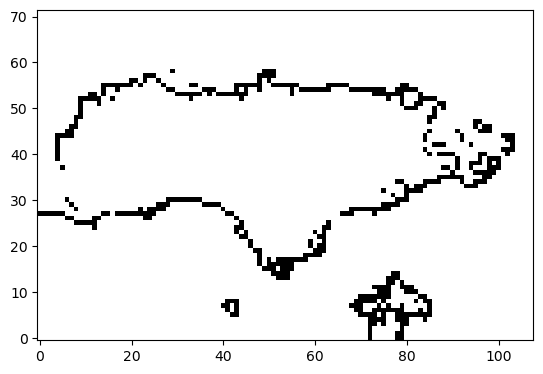

In [267]:
plt.imshow(J_grid, origin="lower", cmap="binary")

In [64]:
import calendar

def generate_date_dict(year=2022, month=11):
    # Get the number of days in the specified month and year
    num_days = calendar.monthrange(year, month)[1]
    
    date_dict = {}

    # Loop through all days in the month
    for day in range(1, num_days+1):
        key_format = f"{year}-{month:02}-{day:02}"
        value_format = f"{day:02}{calendar.month_abbr[month].upper()}{year}"
        date_dict[key_format] = value_format

    return date_dict

# Test
print(generate_date_dict())


{'2022-11-01': '01NOV2022', '2022-11-02': '02NOV2022', '2022-11-03': '03NOV2022', '2022-11-04': '04NOV2022', '2022-11-05': '05NOV2022', '2022-11-06': '06NOV2022', '2022-11-07': '07NOV2022', '2022-11-08': '08NOV2022', '2022-11-09': '09NOV2022', '2022-11-10': '10NOV2022', '2022-11-11': '11NOV2022', '2022-11-12': '12NOV2022', '2022-11-13': '13NOV2022', '2022-11-14': '14NOV2022', '2022-11-15': '15NOV2022', '2022-11-16': '16NOV2022', '2022-11-17': '17NOV2022', '2022-11-18': '18NOV2022', '2022-11-19': '19NOV2022', '2022-11-20': '20NOV2022', '2022-11-21': '21NOV2022', '2022-11-22': '22NOV2022', '2022-11-23': '23NOV2022', '2022-11-24': '24NOV2022', '2022-11-25': '25NOV2022', '2022-11-26': '26NOV2022', '2022-11-27': '27NOV2022', '2022-11-28': '28NOV2022', '2022-11-29': '29NOV2022', '2022-11-30': '30NOV2022'}


In [65]:
date_dict = generate_date_dict()


KeyError: 0

In [86]:
def plotFrontLineISW(key, value, lmbda = 5, nu = 0.01):
        # merge in ISW shapefile
    isw = gpd.read_file("s3://ipsos-dvd/fdd/data/in/ukr/Ukraine_Conflict_Mapping_ARCGIS_Shapefiles/Russian_CoT_in_Ukraine_Shapefiles/UkraineControlMapAO" + value + ".zip")
    isw = isw.to_crs(grid.crs)
    
    print("ISW exists")
    
    grid = gpd.read_file(bsdir + "grid_daily/" + key + ".geojson")
    
    X1 = np.array(grid.geometry.centroid.x)
    X2 = np.array(grid.geometry.centroid.y)
    X = np.stack([X1, X2], axis = 1)

    Y = np.array(grid['count_ratio'])

    # winsorize
    qtile = np.quantile(Y, 0.9)
    Y[Y > qtile] = qtile # 0.5
    
    X = np.stack([X2, X1]).T
    
    # segment
    #--------
    # parameters
    S=16
    N = Y.shape[0]
    #--------
    resolution = 1/int(np.sqrt(N))
    model = FDD(Y, X, level = S, lmbda = lmbda, nu = nu, iter = 10000, tol = 5e-5, pick_nu = "MS", CI=False, rectangle=True, resolution=resolution,
                scripted=False)
    
    results = model.run()
    u = results['u']
    J_grid = results['J']
    
    xmin = np.min(model.X_raw, axis=0)
    xmax = np.max(model.X_raw - xmin)
    X_coord = model.grid_x * xmax +  np.flip(xmin)
    
    X_coord = X_coord.reshape(-1, X_coord.shape[-1])
    Y_coord = u.flatten()
    
    u_gdf = gpd.GeoDataFrame(np.stack([Y_coord, J_grid.flatten()]).T, geometry=gpd.points_from_xy(X_coord[:,0], X_coord[:,1]), crs = grid.crs, columns=['u', 'J_grid'])
    u_gdf.loc[u_gdf['J_grid'] == 0, 'J_grid'] = np.nan  
    
    
    
    fig, ax = plt.subplots(figsize=(10, 6))
    u_gdf.plot(ax=ax, cmap = "binary_r", column="J_grid", alpha=0.8, s=5)
    isw.plot(ax=ax)
    ctx.add_basemap(ax, crs=u_gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)

In [88]:
key = "2022-11-11"
value = date_dict[key]
plotFrontLineISW(key, value, lmbda=10, nu=0.01)

DriverError: '/vsizip/vsis3/ipsos-dvd/fdd/data/in/ukr/Ukraine_Conflict_Mapping_ARCGIS_Shapefiles/Russian_CoT_in_Ukraine_Shapefiles/UkraineControlMapAO11NOV2022.zip' does not exist in the file system, and is not recognized as a supported dataset name.

In [ ]:
## plot segmentation against ISW in loop
for key, value in date_dict.items():
    try:
        print(key, value)
        plotFrontLineISW(key, value)

        file_name = "isw_frontline_" + key + ".png"
        fn = "/home/ubuntu/results/" + file_name
        plt.savefig(fn)
        s3 = boto3.client('s3')
        with open(fn, "rb") as f:
            s3.upload_fileobj(f, "ipsos-dvd", "fdd/results/figs/" + file_name)
    
    except:
        pass
    

#grid = gpd.read_file(bsdir + "grid_daily/" + "2022-11-11.geojson")


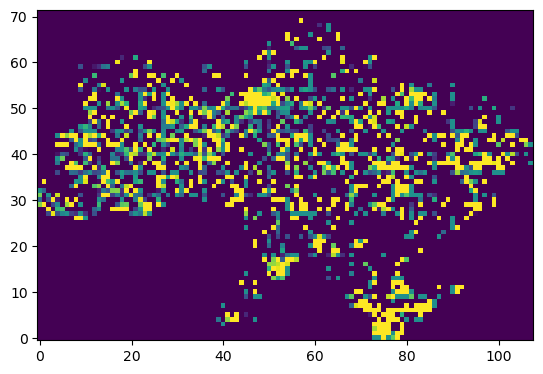

In [82]:
plt.imshow(model.grid_y, origin="lower")

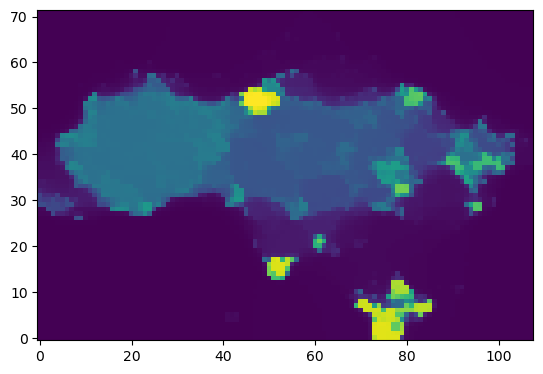

In [83]:
plt.imshow(u, origin="lower")

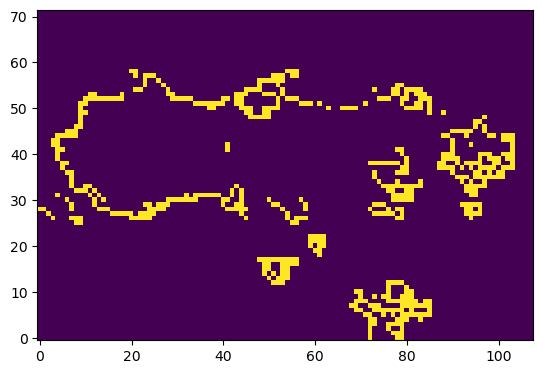

In [84]:
plt.imshow(J_grid, origin="lower")